In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from scipy.signal import find_peaks
from scipy.optimize import curve_fit



# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

Already have data downloaded for Gaia ID 3296334520042680064.
If you want to check for new data, run `janet.update()`.
No postcard object will be created for this target.
### Running Simple Astropy Lomb-Scargle on Sector 5 on star 3296334520042680064 ###
### Completed Simple Astropy Lomb-Scargle for Sector 5 on star 3296334520042680064 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 32 on star 3296334520042680064 ###
### Completed Simple Astropy Lomb-Scargle for Sector 32 on star 3296334520042680064 ###
### Saved results ###
### Running Wavelet Estimation on star 3296334520042680064 ###


/Users/Anaconda/anaconda3/envs/michael/lib/python3.8/site-packages/jazz_hands-0.0.3-py3.8.egg/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

### Completed Wavelet Estimation on star 3296334520042680064 ###
### Saved results ###
### Running ACF Estimation on star 3296334520042680064 ###
### Completed ACF Estimation on star 3296334520042680064 ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###


/Users/oliver hall/Research/michael/Examples/../michael/methods.py:289: UserWarning: The highest peak in the ACF lies outside the period range of your search.
  warnings.warn("The highest peak in the ACF lies outside the period range of your search.")
/Users/oliver hall/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/oliver hall/Research/michael/Examples/../michael/plotting.py:332: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{j.output_path}/{j.gaiaid}/output.pdf', rasterized=True)



------ Decoding Overall Period Flag 1 ------
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 

### Saved results ###


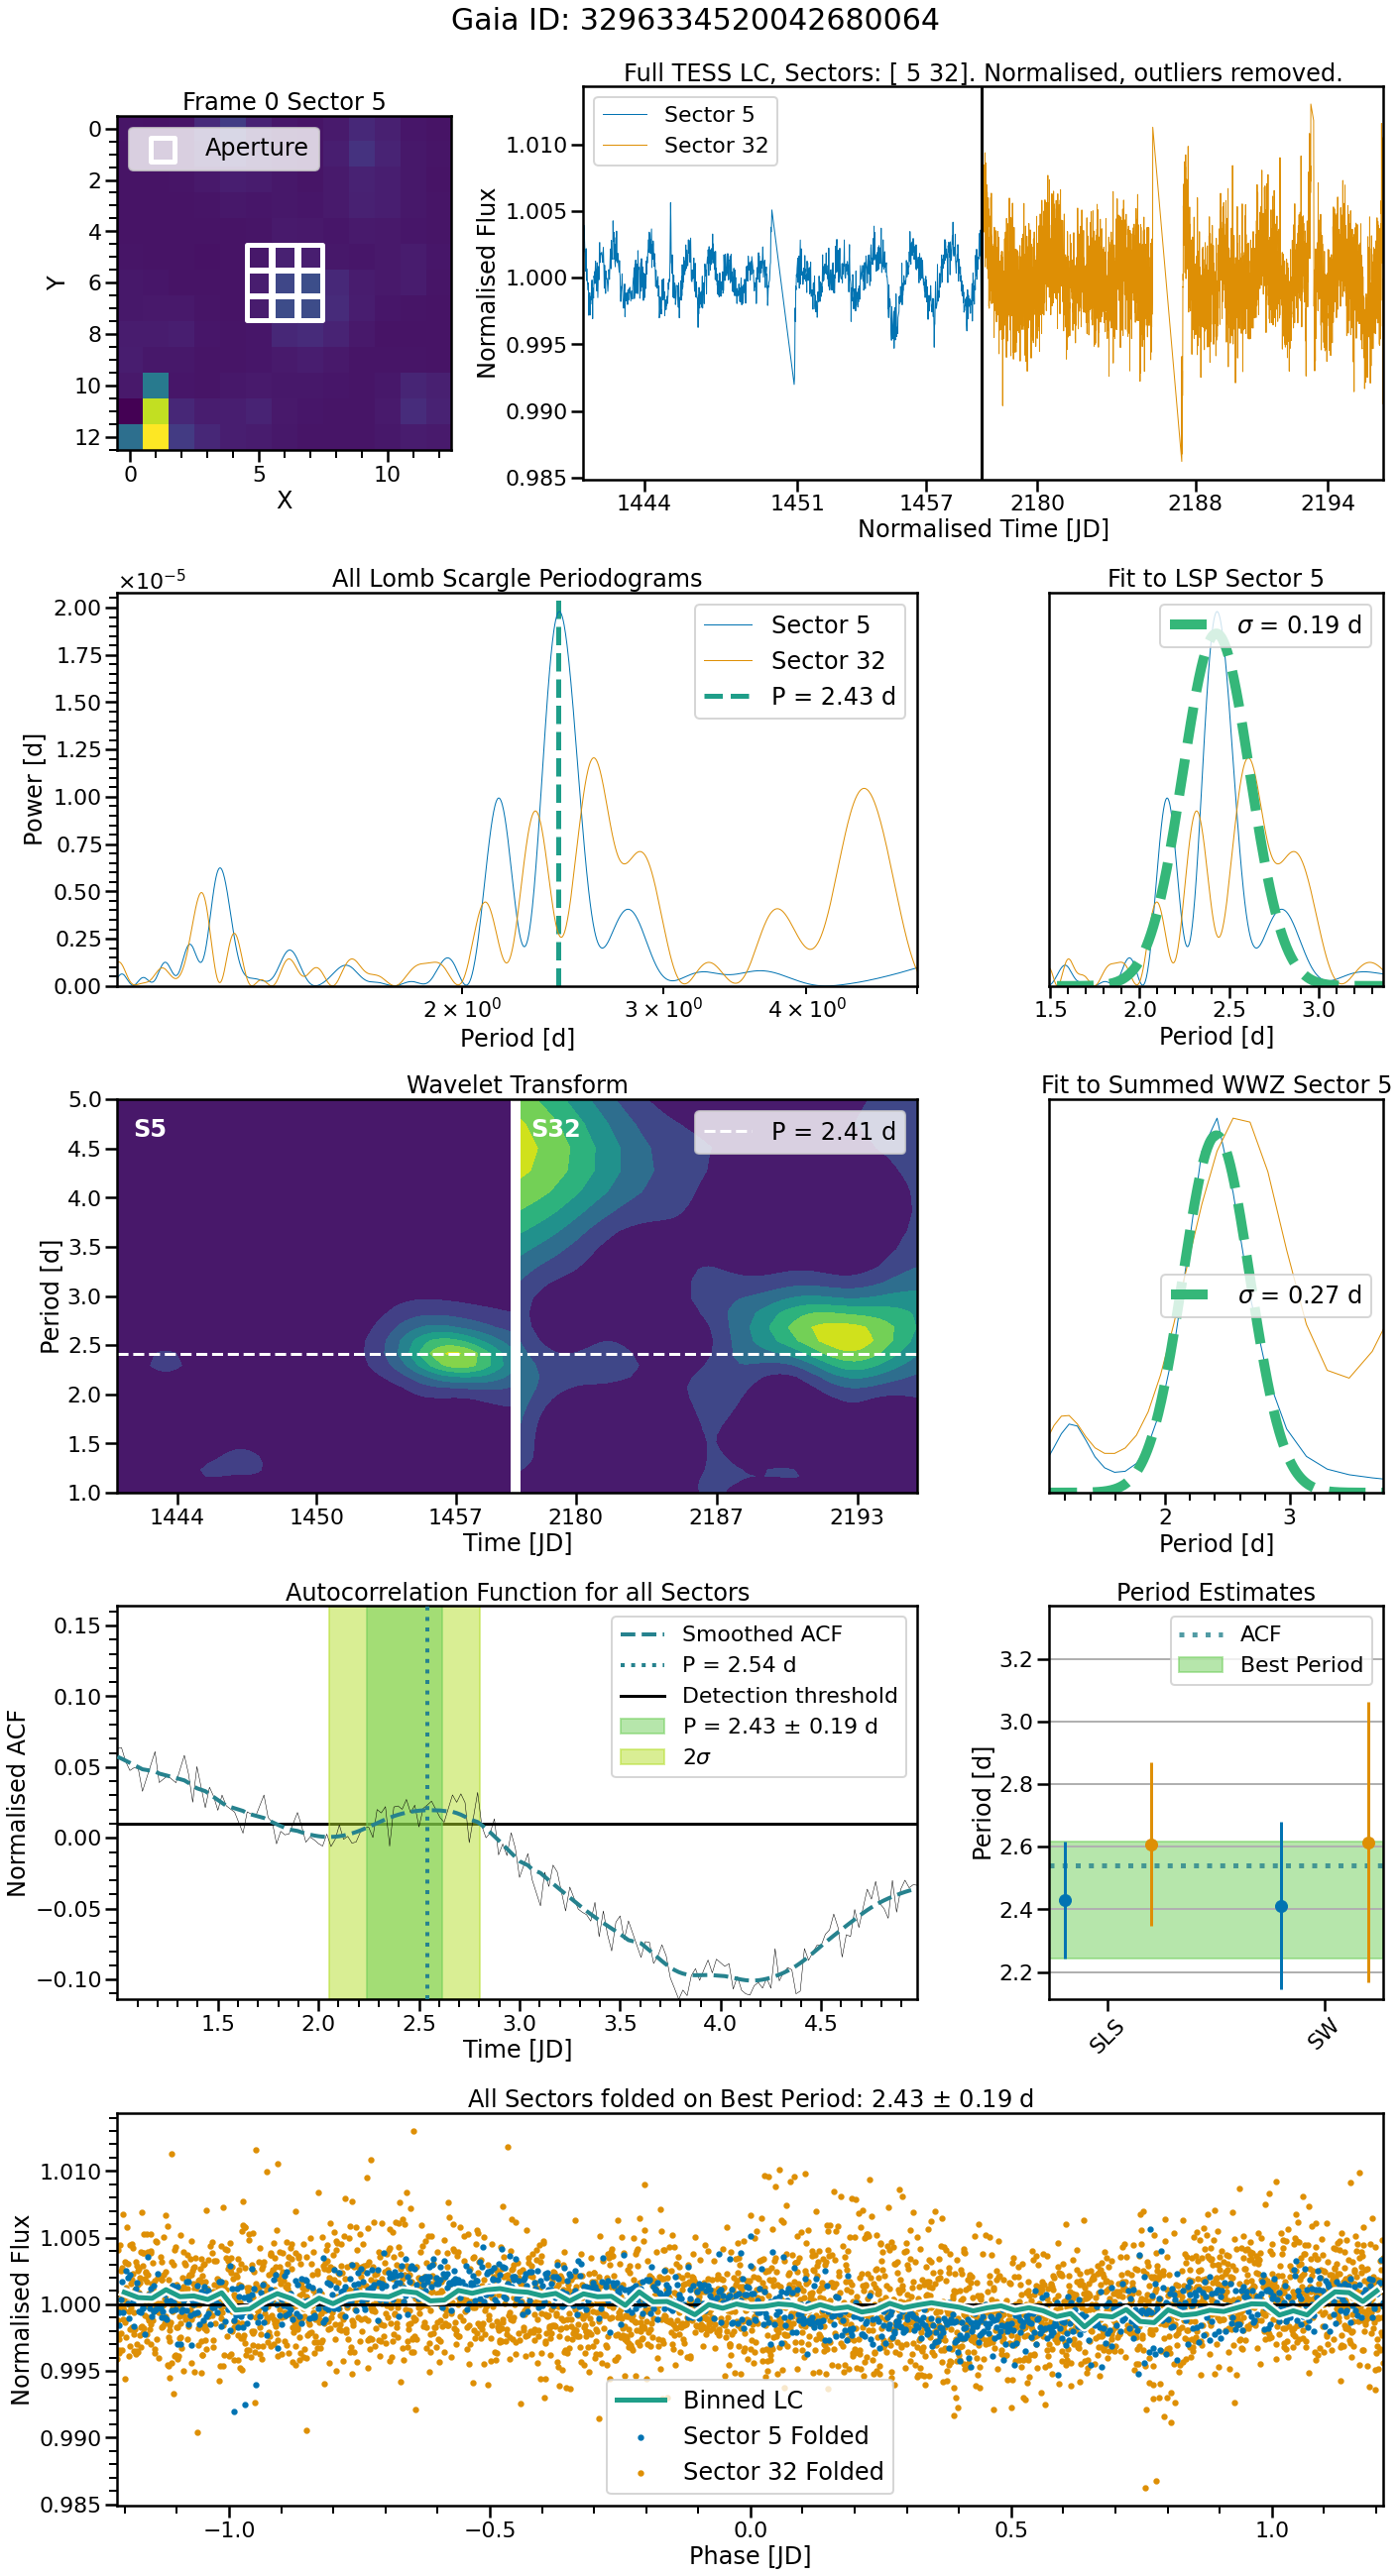

In [3]:
j = janet.boot(uni, index=24)
j.run(period_range = (1., 5.))

No handles with labels found to put in legend.


NameError: name 'text' is not defined

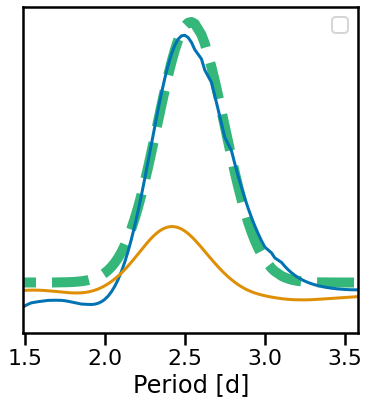

In [9]:
from scipy import interpolate
import seaborn as sns
import lightkurve as lk
from scipy.optimize import curve_fit
from michael.utils import _gaussian_fn
cmap = sns.color_palette('viridis', 8)
period_range = j.period_range

if not j.gaps:
    print('Not quite here yet')
    
else:
    for sector in list(j.sectors):
        # Extract the wavelet information
        w = np.flip(np.sum(j.void[f'{sector}_wwz'], axis=1))
        x = np.flip(1./j.void[f'{sector}_wt'].nus)
        f = interpolate.interp1d(x, w)
        
        # Calculate the ACF for the relevant sector
        lc = j.void[f'clc_{sector}']
        acf = np.correlate(lc.flux.value-1, lc.flux.value-1, mode='full')[len(lc)-1:]
        lag = lc.time.value - lc.time.value.min()
        norm_acf = acf/np.nanmax(acf)
        acflc = lk.LightCurve(time=lag, flux=norm_acf)

        vizacf = acflc[(acflc.time.value <= period_range[1])]
        vizacf = vizacf[(vizacf.time.value >= period_range[0])]
        
        # Calculate the compound ACF
        xnew = vizacf.time.value
        wnew = f(xnew)
        cacf = vizacf * (wnew/np.nanmax(wnew))
        
        # Smooth the  CACF
        sd = np.ceil(.1 / np.median(np.diff(cacf.time.value)))
        gauss = Gaussian1DKernel(sd)
        cacfsmoo = convolve(cacf.flux.value, gauss, boundary='extend')

        # Identify the first 10 maxima above a threshold of 0.01
        cpeaks, _ = find_peaks(cacfsmoo, height = 0.01)
        
        # No peaks found
        if len(cpeaks) == 0:
            j.results.loc[sector, 'CACF'] = np.nan
        
        # Save the metadata
        j.void[f'{sector}_vizacf'] = vizacf
        j.void[f'{sector}_cacf'] = cacf
        j.void[f'{sector}_cacfsmoo'] = cacfsmoo
        j.void[f'{sector}_cpeaks'] = cpeaks        

        P = cacf[cpeaks[0]]

        lolim = 0.8*P['time'].value
        if lolim < period_range[0]:
            lolim = period_range[0]
        uplim = 1.2*P['time'].value
        if uplim > period_range[1]:
            uplim = period_range[1]

        popt, pcov = curve_fit(_gaussian_fn, cacf.time.value, cacfsmoo,
                               p0 = [P['time'].value, 0.1*P['time'].value, P['flux'].value],
                               bounds = ([lolim, 0., 0.9*P['flux'].value], 
                                         [uplim, 0.25*P['time'].value, 1.1*P['flux'].value]))

        j.results.loc[sector, 'CACF'] = popt[0]
        j.results.loc[sector, 'e_CACF'] = popt[1]
        j.void[f'{sector}_cacf_popt'] = popt      
        
        # End!
        
best_cacf = '5'

fig, ax = plt.subplots(figsize=(6, 6))
ax.get_yaxis().set_visible(False)

x = j.void[f'{best_cacf}_cacf'].time.value
ax.plot(x,
        _gaussian_fn(x, *j.void[f'{best_cacf}_cacf_popt']), ls='--', lw=10, c=cmap[5], zorder=2)
#         label = rf'$\sigma$ = {j.results.loc["best", "e_SLS"]:.2f} d')
ax.set_xlim(j.void[f'{best_cacf}_cacf_popt'][0] - 5*j.void[f'{best_cacf}_cacf_popt'][1],
                j.void[f'{best_cacf}_cacf_popt'][0] + 5*j.void[f'{best_cacf}_cacf_popt'][1])

for s in j.sectors:
    ax.plot(j.void[f'{s}_cacf'].time.value, j.void[f'{s}_cacfsmoo'])
    
ax.legend(loc='best', fontsize=20)
ax.set_xlabel('Period [d]')
ax.set_title(f'Fit to CACF {text}')        

In [ ]:
list(j.void)

In [ ]:
from scipy.optimize import curve_fit
from michael.utils import _gaussian_fn
P = cacf[cpeaks[0]]

lolim = 0.8*P['time'].value
if lolim < period_range[0]:
    lolim = period_range[0]
uplim = 1.2*P['time'].value
if uplim > period_range[1]:
    uplim = period_range[1]

popt, pcov = curve_fit(_gaussian_fn, cacf.time.value, cacfsmoo,
                       p0 = [P['time'].value, 0.1*P['time'].value, P['flux'].value],
                       bounds = ([lolim, 0., 0.9*P['flux'].value], [uplim, 0.25*P['time'].value, 1.1*P['flux'].value]))
    
j.results.loc[sector, 'CACF'] = popt[0]
j.results.loc[sector, 'e_CACF'] = popt[1]


ax.plot(j.void[f'p_{best_sls}'],
        _gaussian_fn(j.void[f'p_{best_sls}'], *j.void[f'popt_{best_sls}']), ls='--', lw=10, c=cmap[5], zorder=2,
        label = rf'$\sigma$ = {j.results.loc["best", "e_SLS"]:.2f} d')
ax.set_xlim(j.void[f'popt_{best_sls}'][0] - 5*j.void[f'popt_{best_sls}'][1],
                j.void[f'popt_{best_sls}'][0] + 5*j.void[f'popt_{best_sls}'][1])

In [ ]:
j.results

In [ ]:
j.void['5_vizacf'].plot()
j.void['32_vizacf'].plot()

In [ ]:
plt.plot(x, w)
plt.plot(xnew, wnew)

In [ ]:
acfsmoo = j.void['acfsmoo']
compacf = (smooacf * (wnew/wnew.max()))

In [ ]:
plt.plot(vizacf.time.value, compacf)

In [ ]:
xnew.max()

In [ ]:
x.max()

Now we smooth following the acf's time array

In [ ]:
wwz = j.void[f'{j.sectors[0]}_wwz']
max = np.nanmax(wwz)
wwz /= max
for s in j.sectors[1:]:
    add = j.void[f'{s}_wwz']/max
    wwz = np.vstack((wwz, add[:, :wwz.shape[1]]))
w = np.sum(wwz, axis=1)
nus = j.void['5_wt'].nus
p = 1/nus
plt.plot(p, w)

In [ ]:
pacf = j.void['']

In [ ]:
acfsmoolc = lk.LightCurve(time = j.void['acflc'].time.value, flux = acfsmoo)

In [ ]:
Model = pm.Model()
P = acfsmoolc.time.value
F = acfsmoolc.flux.value

with Model:
    A0 = pm.Uniform('A0', 0., 1., testval=0.05)
    A1 = pm.Uniform('A1', 0., 10., testval=0.5)
    yy = pm.Deterministic('yy', (1-A0)*np.exp(-P/A1) + A0)
    y = pm.Normal('like', mu=yy, sigma = np.std(F),
                 observed=F)

In [ ]:
with Model:
    trace = pm.sample()

In [ ]:
yy = np.median(trace['yy'], axis=0)
normacf = acfsmoolc - yy

In [ ]:
binned = normacf.bin()

In [ ]:
fig, ax= plt.subplots()
ax.legend()